## Setup

In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math

from sklearn.utils import shuffle
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.transform import rotate, warp, ProjectiveTransform, SimilarityTransform, matrix_transform
from skimage import img_as_ubyte, img_as_float
from sklearn.model_selection import train_test_split

## Load Data

In [2]:
def parse_recordings(paths):
    lines = []
    
    for data_path in paths:
        with open(os.path.join(data_path, r'driving_log.csv')) as csvfile:
            reader = csv.reader(csvfile)
            next(reader, None) # skip headers
            
            for line in reader:
                for i in range(3):
                    # Rebuild the file name because the absolute paths in driving_log are
                    # not portable
                    line[i] = os.path.join(data_path, 'IMG', os.path.basename(line[i]))
                
                lines.append(line)
    
    # N x 3 Matrix containing the image paths (center, left, right) 
    images = []
    # N x 1 Matrix containing the steering while angles
    measurements = []

    for line in lines[1:]:
        images.append([line[0], line[1], line[2]])
        
        measurement = float(line[3])
        measurements.append(measurement)
        
    images = np.array(images)
    measurements = np.array(measurements)
    
    return images, measurements

In [3]:
#data_paths = [ r"D:\recordings\data\data", r"D:\recordings\r1", r'D:\recordings\r4', r"D:\recordings\r2", r"D:\recordings\r3" ]
data_paths = [ r"D:\recordings\data\data", r"D:\recordings\r2", r"D:\recordings\r3" ]

X_data, y_data = parse_recordings(data_paths)

print('total number of samples')
print(X_data.shape)

total number of samples
(13473, 3)


In [4]:
def show_all_images(X):
    num = len(X)
    
    plt.figure(figsize=(num*10, 10))
    
    key = int(100 + 10*num + 1)
    
    for index in range(num):
        image = X[index].squeeze()
        plt.subplot(key)
        plt.imshow(image)
        key += 1
    
    plt.show()
    
def show_random_images(X, num=1, ind = None):
    if ind == None:
        ind = np.random.randint(0, len(X), num)
        
    show_all_images(X[ind])

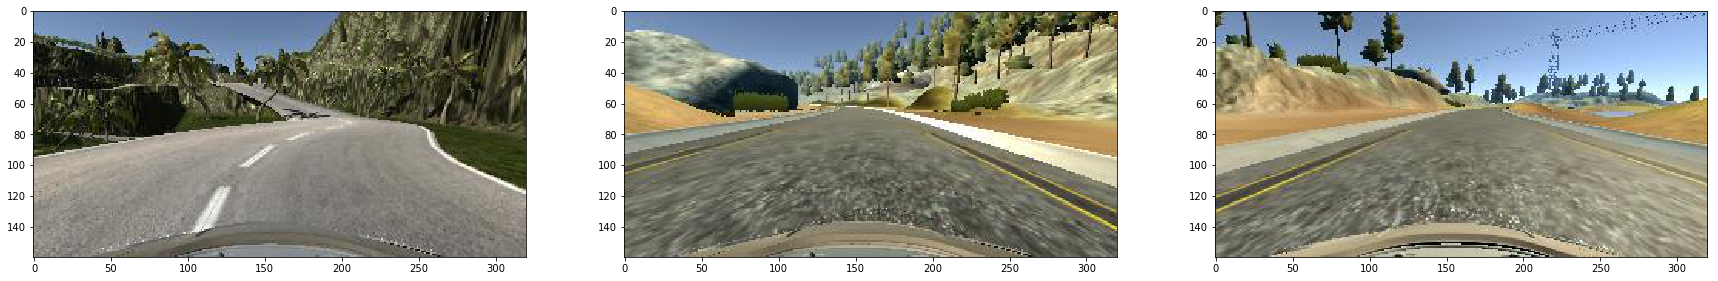

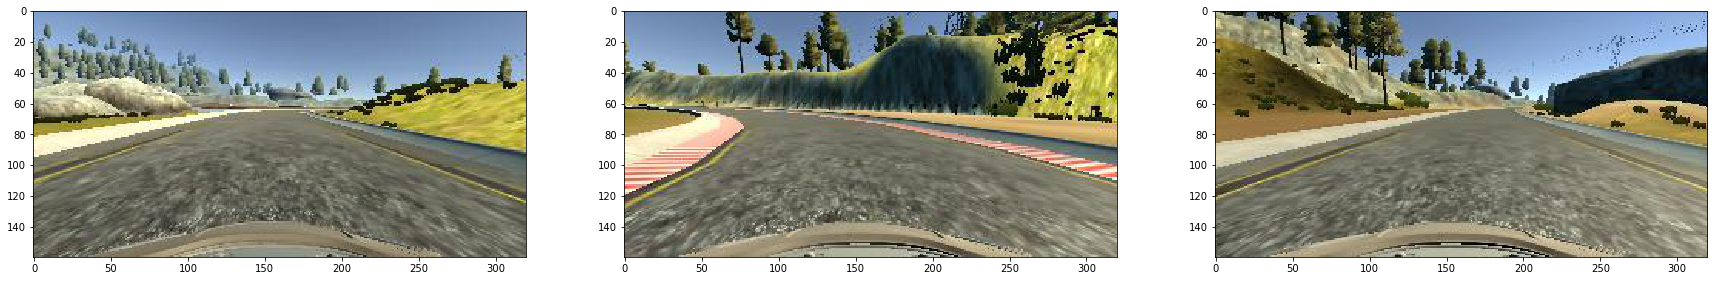

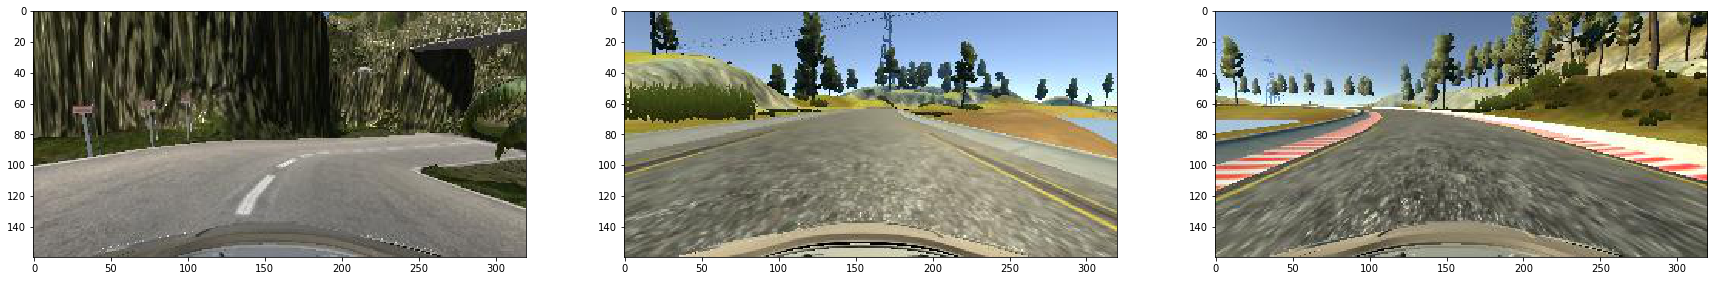

In [5]:
def load_single(img_path):
    return np.array(img_as_float(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)), dtype=np.float32)

def load_all(img_paths):
    images = [load_single(img) for img in img_paths]
    
    return np.array(images, dtype=np.float32)

def load_and_show_images(imgs):
    show_all_images(load_all(imgs))

def load_and_show_random_images(imgs,  num=1, ind = None):
    if ind == None:
        ind = np.random.randint(0, len(imgs), num)
        
    load_and_show_images(imgs[ind])

load_and_show_random_images(X_data[:, 0], 3)
load_and_show_random_images(X_data[:, 0], 3)
load_and_show_random_images(X_data[:, 0], 3)

## Data Statistics

Original distribution of features / labels


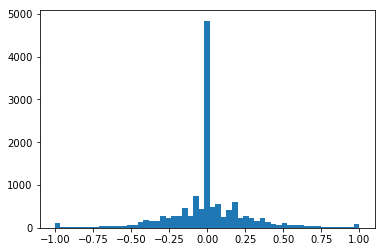

-1.0
1.0


In [6]:
print("Original distribution of features / labels")
plt.hist(y_data, 55)
plt.show()
print(np.min(y_data))
print(np.max(y_data))

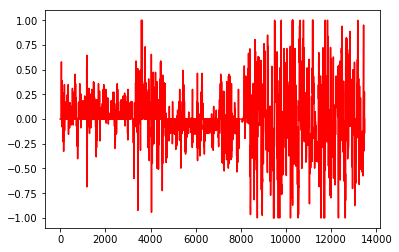

In [7]:
plt.plot(y_data, 'r')
plt.show()

## Filtering

In [8]:
# Equalizes the given X, y samples using histogram randomization
def equalize_angles(X, y, n_bins = 1200, max_number = 50):
    X_out = []
    y_out = []
    
    start = 0
    
    # Partition the interval [0, 1.2] into n_bins bins and
    # choose at random at most max_number of representatives
    for end in np.linspace(0, 1.2, n_bins):
        ind = [i for i in range(len(X)) if abs(y[i]) >= start and abs(y[i]) < end]
        
        if len(ind) > max_number:
            ind = np.random.choice(ind, max_number)
        
        X_out.append(X[ind])
        y_out.append(y[ind])
        
        start = end
        
    return np.concatenate(X_out, axis=0), np.concatenate(y_out, axis=0)
        
X_f, y_f = equalize_angles(X_data, y_data)

Filtered distribution of features / labels
(7141, 3)
(7141,)


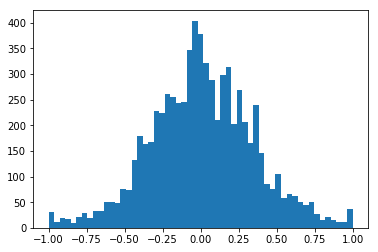

In [9]:
print("Filtered distribution of features / labels")
print(X_f.shape)
print(y_f.shape)
plt.hist(y_f, 55)
plt.show()

(21423,)
(21423,)


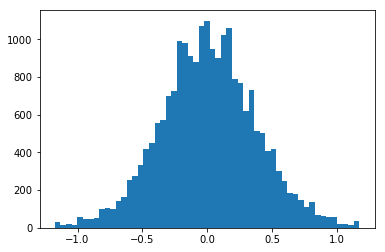

In [10]:
def select_cameras(X, y, use_side_cameras = False):
    steering_angle_correction = 10. / 180. * math.pi # 10 deg

    X_side = np.array(X[:, 0], copy=True)
    if use_side_cameras:
        X_side = np.append(X_side, X[:, 1], axis = 0)
        X_side = np.append(X_side, X[:, 2], axis = 0)

    y_side = np.array(y, copy=True)
    if use_side_cameras:
        y_side = np.append(y_side, y + steering_angle_correction, axis = 0)
        y_side = np.append(y_side, y - steering_angle_correction, axis = 0)
    
    return X_side, y_side

X_side, y_side = select_cameras(X_f, y_f, True)

print(X_side.shape)
print(y_side.shape)
plt.hist(y_side, 55)
plt.show()

In [ ]:
import gc

gc.collect()

### Save filtered list to file

In [ ]:
import pickle

pickle.dump( (X_f, y_f), open('filtered.p', 'wb'))

### Load filtered list from file

In [ ]:
import pickle


with open('filtered.p', 'rb') as pkl_file:
    X_f, y_f = pickle.load(pkl_file)

print("Filtered distribution of features / labels")
print(X_f.shape)
print(y_f.shape)
plt.hist(y_f, 55)
plt.show()

## Data Augmentation

In [11]:
def apply_random_flip_single(X, y):
    flip = np.random.randint(-1, 2)
    
    if flip < 0:
        X = X[:, ::-1, :]
        y = -y
            
    return X, y

In [12]:
def apply_random_brightness_single(X):
    coin = np.random.randint(0, 2) # either 0 or 1
    
    if coin == 0:
        # make it brither
        gamma = np.random.uniform(0.3, 1.0)
        
        return adjust_gamma(X, gamma)
    else:
        # make it darker
        factor = np.random.uniform(0.2, 1.0)
        
        hsv = cv2.cvtColor(X, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)
        
        v = factor * v
    
        return np.array(cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2RGB))

In [13]:
def apply_random_shifting_single(X, y, max_delta = 80, ratio = 0.001):
    delta = np.random.uniform(-max_delta, max_delta)
        
    offsetx = delta
    offsety = 0
    
    tf_shift = SimilarityTransform(translation=[offsetx, offsety])
    
    X_copy = warp(X, tf_shift)
    y += -ratio*delta
    
    return X_copy, y

In [14]:
def apply_random_shadow_single(X):
    img_width, img_height = X.shape[0:2]
    
    alpha = np.random.uniform(0.1, 0.85)
    x = np.random.uniform(0, img_width, 2)
    width = np.random.uniform(80, 240, 2)
    
    points = np.array([[x[0],0], [x[1],img_height], [min(img_width,x[1] + width[1]),img_height], [min(x[0]+width[0],img_width),0]], np.int32)
    points = points.reshape((-1,1,2))
    shadow_color = (0,0,0)
    
    X_copy = cv2.cvtColor(X, cv2.COLOR_RGB2RGBA)
    X_overlay = np.array(X_copy, copy=True)
    X_overlay = cv2.fillPoly(X_overlay, [points], shadow_color)
    X_temp = np.empty(X_copy.shape, dtype=np.float32)
    
    cv2.addWeighted(X_copy, alpha, X_overlay, 1.-alpha, 0, X_temp)
    
    return cv2.cvtColor(X_temp, cv2.COLOR_RGBA2RGB)

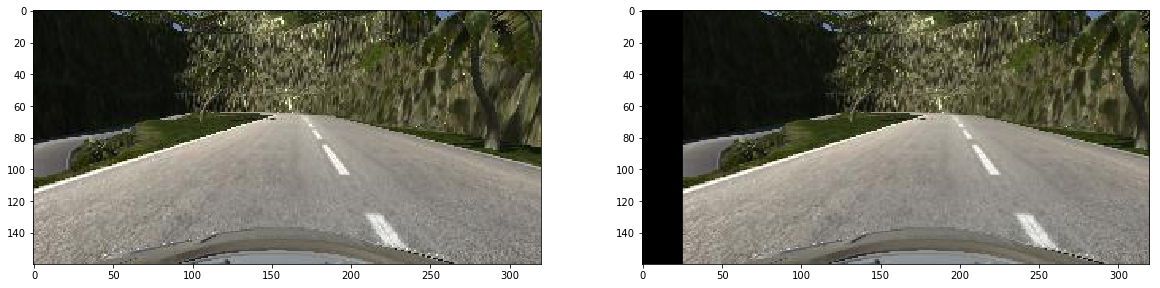

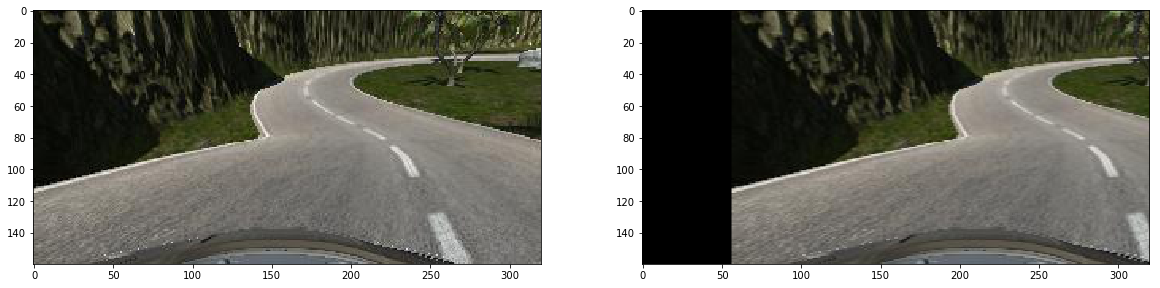

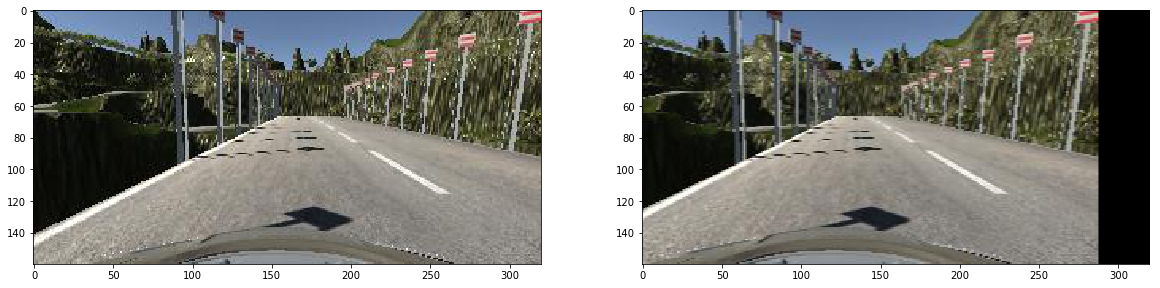

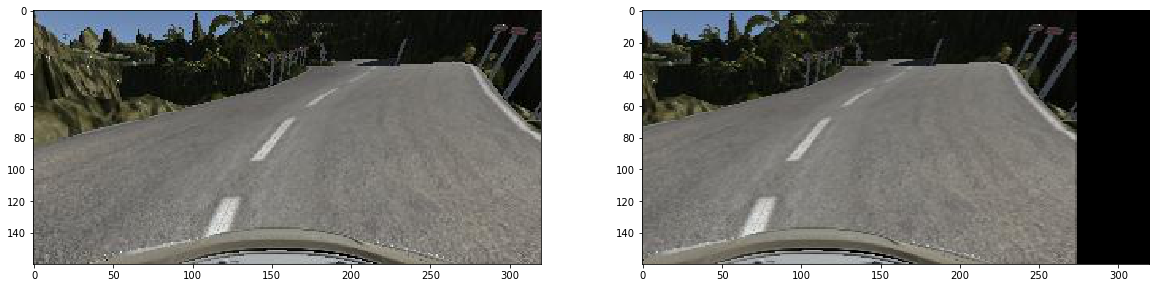

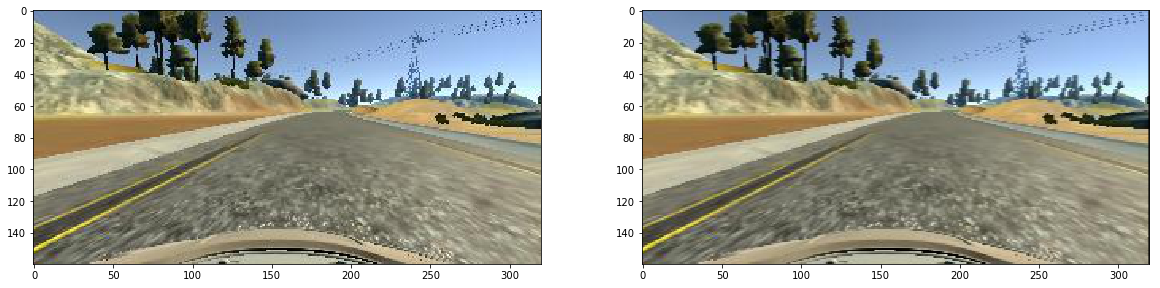

In [15]:
def shift_single_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_shift, y_shift = apply_random_shifting_single(X_img, 0)
    
    plt.subplot(122)
    plt.imshow(X_shift)
    plt.show()
    
for i in range(5):
    shift_single_demo()

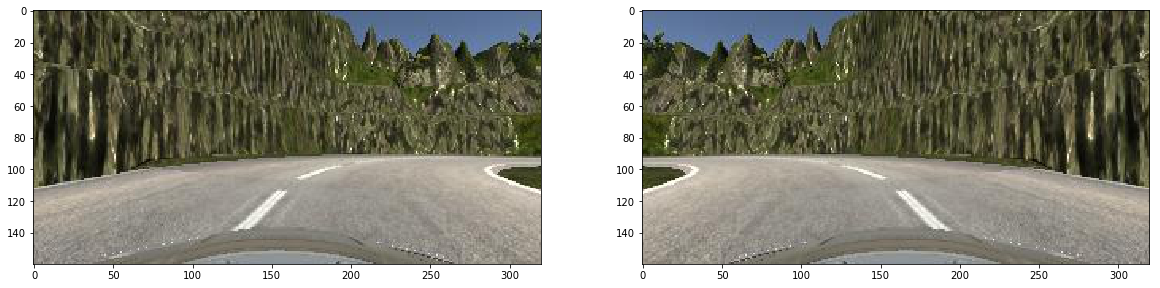

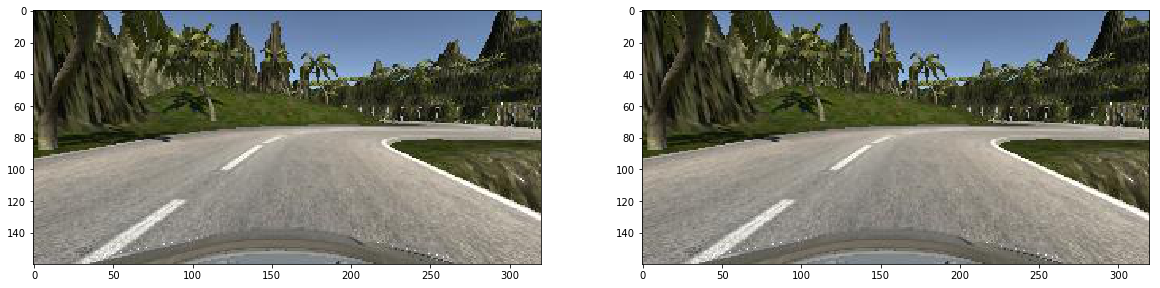

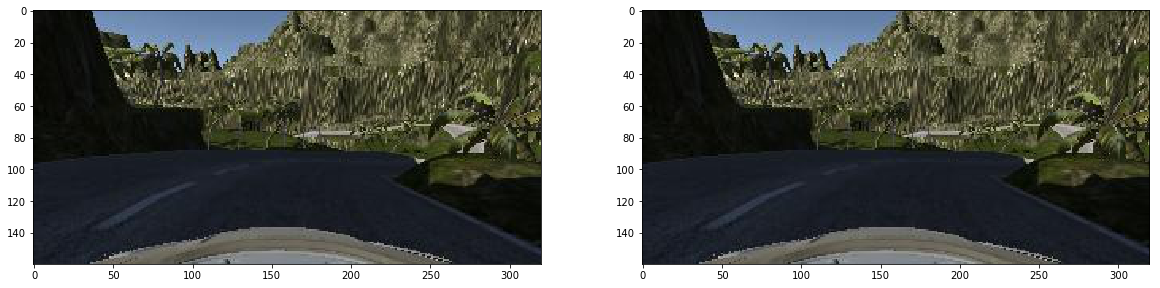

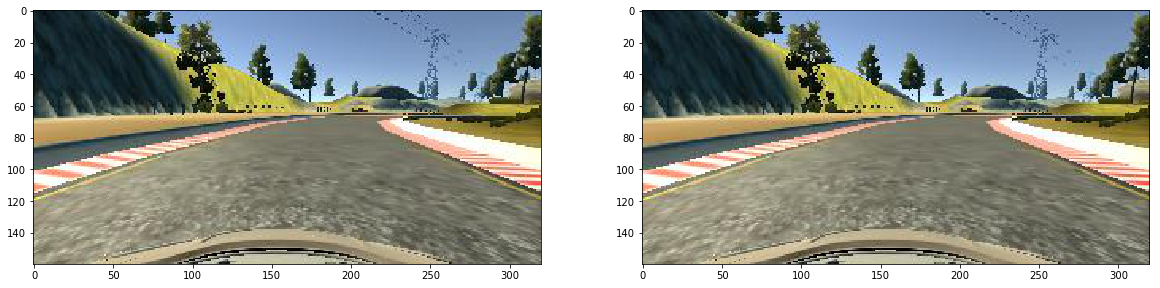

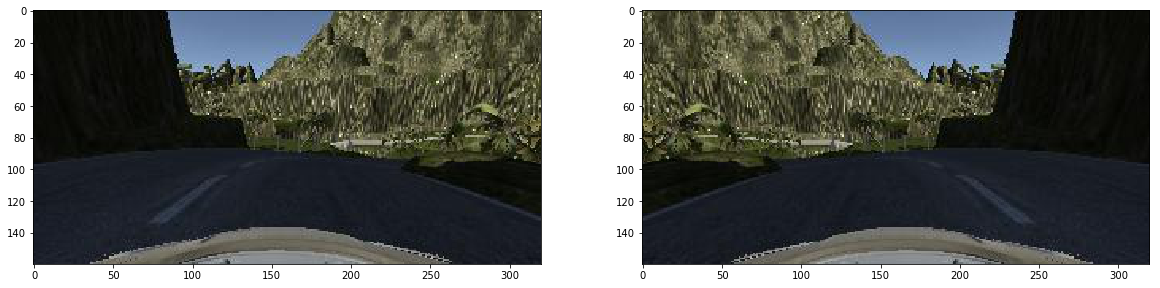

In [16]:
def flip_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_flip, y_flip = apply_random_flip_single(X_img, 1)
    
    plt.subplot(122)
    plt.imshow(X_flip)
    plt.show()
    
for i in range(5):
    flip_demo()

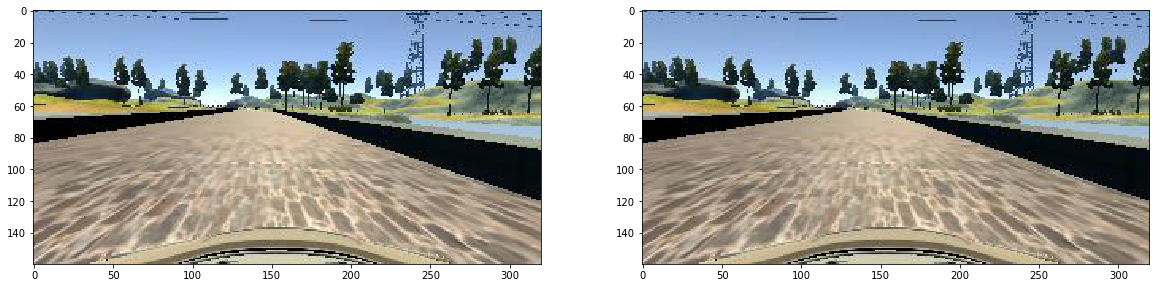

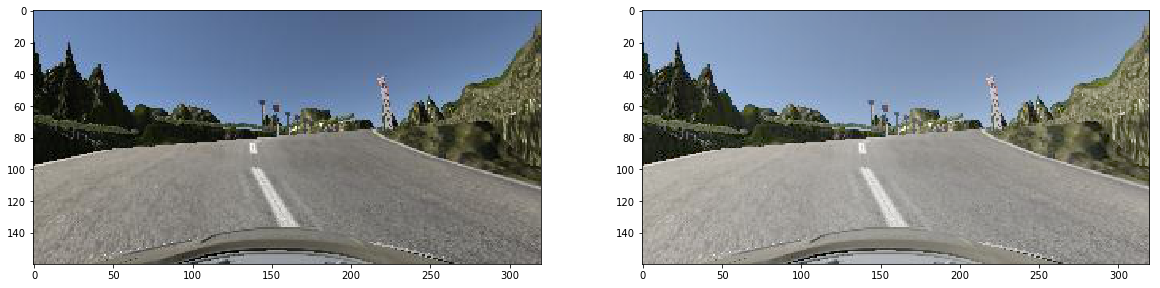

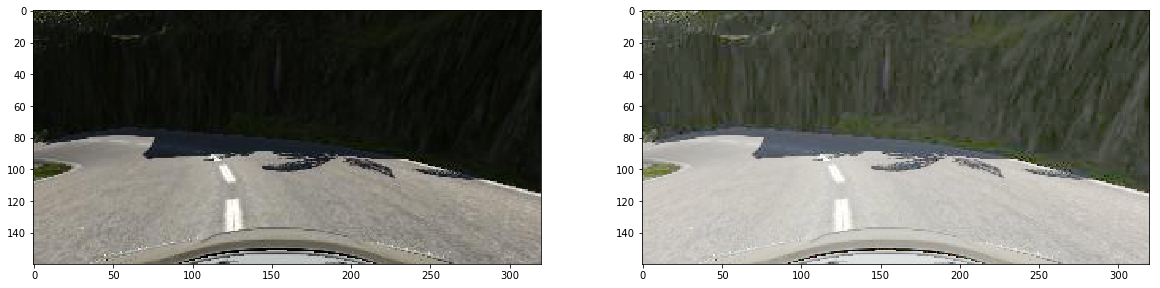

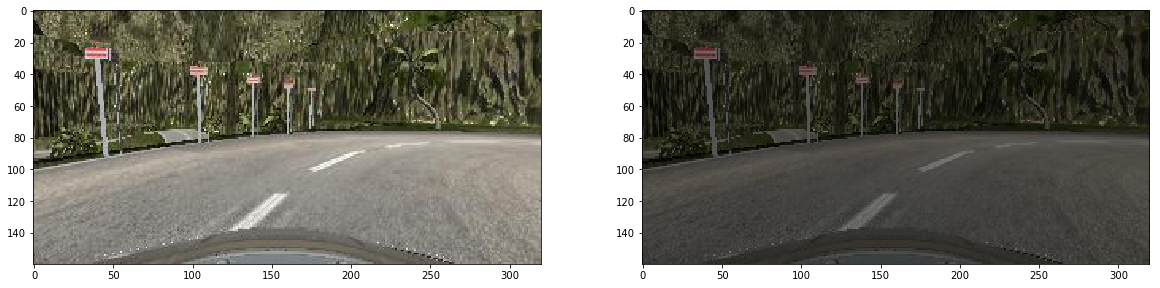

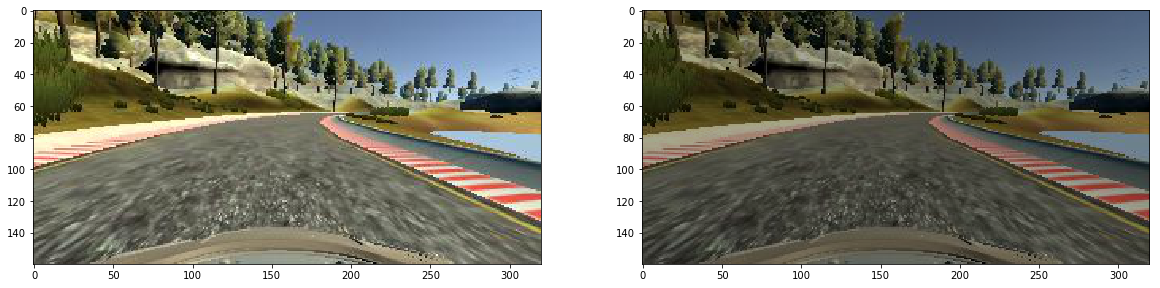

In [17]:
def shift_brightness_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_bright = apply_random_brightness_single(X_img)
    
    plt.subplot(122)
    plt.imshow(X_bright)
    plt.show()

for i in range(5):
    shift_brightness_demo()

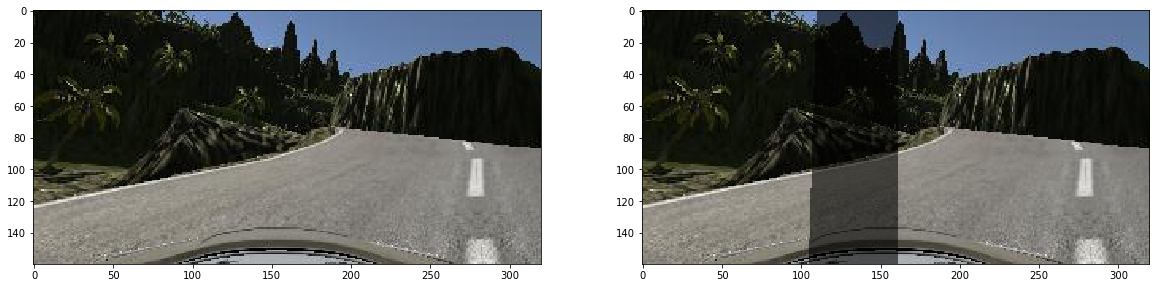

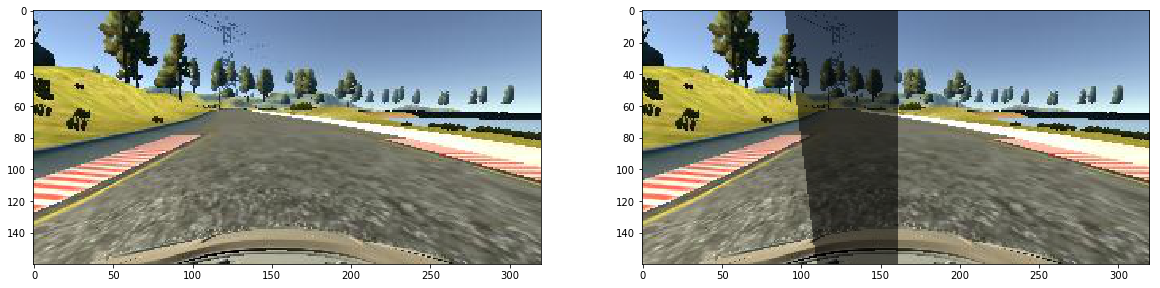

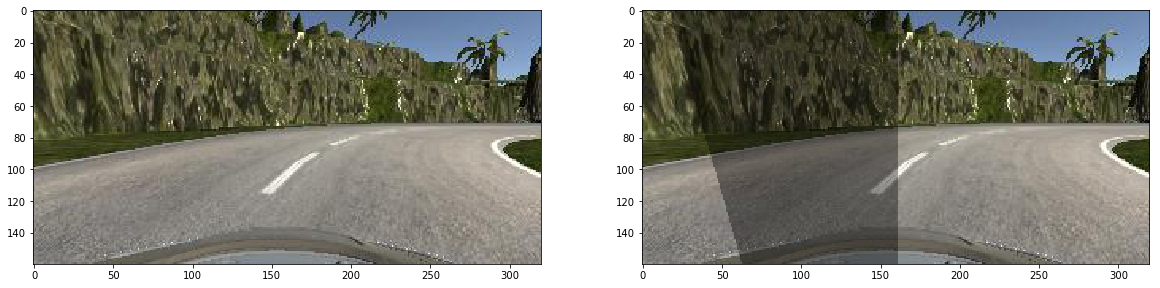

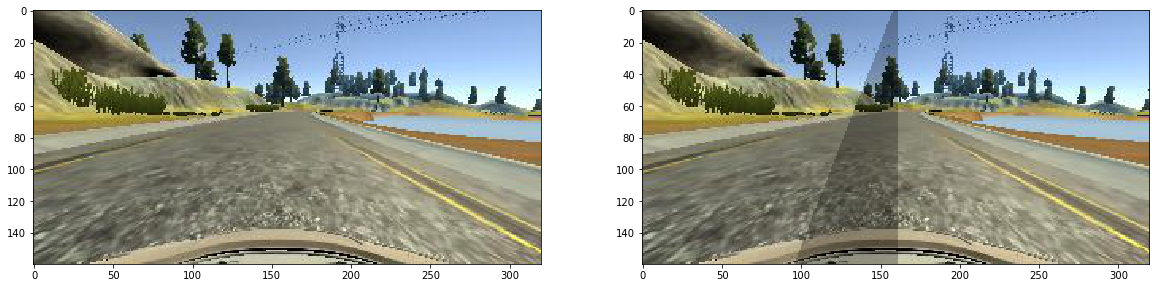

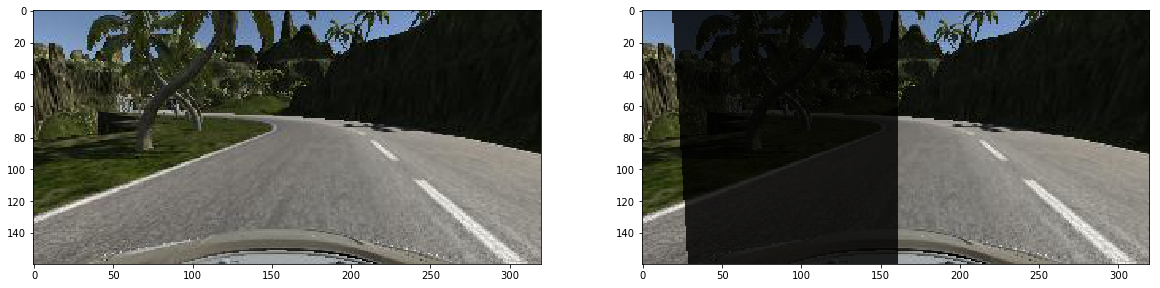

In [18]:
def shadow_demo():
    X_img = load_single(X_f[np.random.randint(len(X_f)), 0])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.imshow(X_img)
    
    X_shadow = apply_random_shadow_single(X_img)
        
    plt.subplot(122)
    plt.imshow(X_shadow)
    plt.show()
    
for i in range(5):
    shadow_demo()

In [19]:
def generate_samples(X, y, augment=False):
    # apply random steering angle histogram equalization
    X, y = equalize_angles(X, y)
    X, y = select_cameras(X, y, augment)
    
    n_samples = len(X)
    batch_size = 128
    ind = np.random.permutation(n_samples)
    count = 0
    
    #print('samples: ', n_samples, ' bs: ', batch_size, X.shape, y.shape)
    
    while True:
        for batch in range(0, n_samples, batch_size):
            batch_ind = ind[batch:(batch+batch_size)]
            
            X_b = load_all(X[batch_ind])[:, 50:130, :, :]
            y_b = np.array(y[batch_ind], copy=True)
            
            if augment:
                for i in range(len(batch_ind)):
                    X_b[i] = apply_random_shadow_single(X_b[i])
                    X_b[i] = apply_random_brightness_single(X_b[i])
                    X_b[i], y_b[i] = apply_random_flip_single(X_b[i], y_b[i])
                    X_b[i], y_b[i] = apply_random_shifting_single(X_b[i], y_b[i])
                    
            for i in range(len(batch_ind)):
                X_b[i] = equalize_adapthist(X_b[i])
                
            count += len(batch_ind)
                    
            yield (X_b, y_b)

C:\Users\janm\AppData\Local\Continuum\Miniconda3\envs\jangpu\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(30, 80, 320, 3)


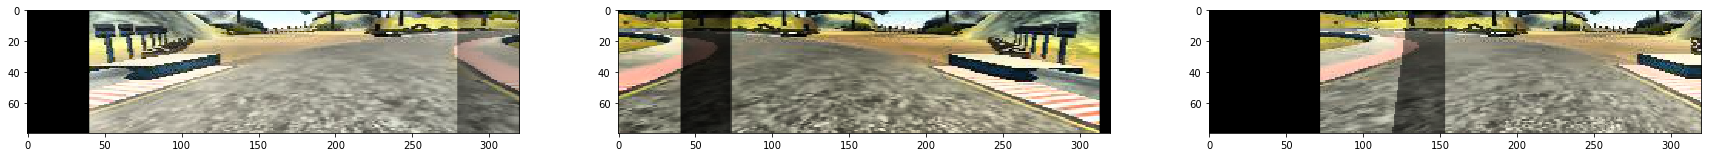

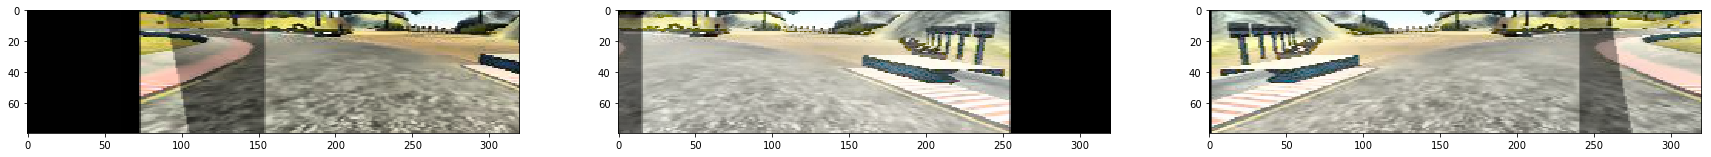

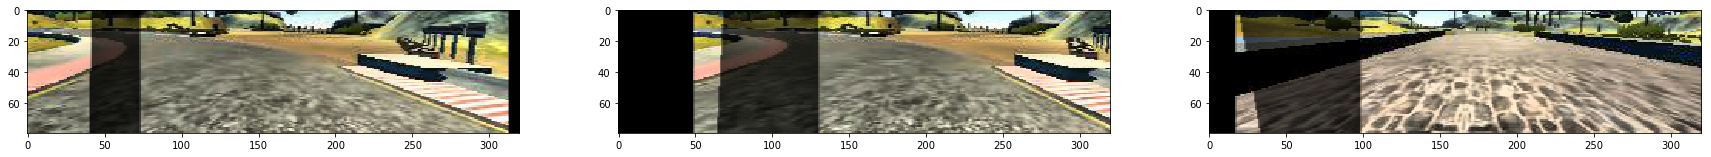

Filtered distribution of features / labels


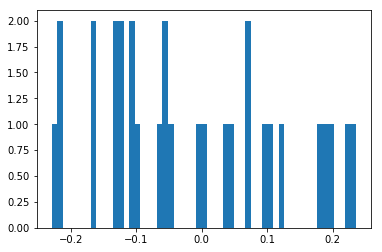

In [20]:
import itertools

Z_test = list(itertools.islice(generate_samples(X_data[0:10], y_data[0:10], True), 9))
X_aug_test, y_aug_test = Z_test[0][0], Z_test[0][1]

print(X_aug_test.shape)

show_random_images(X_aug_test, 3)
show_random_images(X_aug_test, 3)
show_random_images(X_aug_test, 3)

print("Filtered distribution of features / labels")
plt.hist(y_aug_test, 55)
plt.show()

In [21]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation, Lambda, Cropping2D
from keras.optimizers import Adam
from keras.layers import BatchNormalization,Input
from keras import regularizers
from keras.backend import tf as ktf

Using TensorFlow backend.


In [22]:
def get_model():
    model = Sequential()
    
    reg=regularizers.l2(0.0001)
    
    model.add(Conv2D(32, (5,5), activation='relu', strides=(1,1), input_shape=(80,320,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (5,5), activation='relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (5,5), activation='relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    model.add(Dense(1000, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='relu',kernel_regularizer=reg))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001)
    
    model.compile(loss='mse', optimizer=adam, metrics=['mse','accuracy'])
    
    return model

In [ ]:
def get_nvidia_model():
    model = Sequential()
    
    model.add(Lambda(lambda image: ktf.image.resize_images(image, (66, 200)),input_shape=(80,320,3)))
    
    model.add(BatchNormalization(epsilon=0.001, axis=1))

    model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2)))
    model.add(Conv2D(36,(5,5),padding='valid', activation='relu', strides=(2,2)))
    model.add(Conv2D(48,(5,5),padding='valid', activation='relu', strides=(2,2)))
    model.add(Conv2D(64,(3,3),padding='valid', activation='relu', strides=(1,1)))
    model.add(Conv2D(64,(3,3),padding='valid', activation='relu', strides=(1,1)))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001)
    
    model.compile(loss='mse', optimizer=adam, metrics=['mse','accuracy'])
    
    return model

In [23]:
#model = get_nvidia_model()
model = get_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 76, 316, 32)       2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 158, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 154, 64)       51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 77, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 73, 128)       204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 36, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27648)             0         
__________

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=.2)

model.fit_generator(generate_samples(X_train, y_train, True), 
                    steps_per_epoch=int(0.8*len(X_side))/128,
                    epochs=15,
                    validation_data=generate_samples(X_val, y_val, False),
                    validation_steps = int(0.2*len(X_f))/128)

In [ ]:
model.save('model.h5')

In [ ]:
model.summary()

In [ ]:
def preprocess_image(X):
    return equalize_adapthist(img_as_float(X[50:130, :, :]))

In [ ]:
def test_pred():
    ind = range(100)
    
    y_pred = []
    y_actual = y_val[ind]
    
    for i in ind:
        X_img = load_single(X_val[i][0])
        
        plt.imshow(X_img)
        plt.show()
        
        X_prep = preprocess_image(X_img)
        
        y = float(model.predict(X_prep[None, :, :, :], batch_size=1))
        
        print(y, y_val[i])
        
        y_pred.append(y)
        
    plt.plot(y_pred)
    plt.show()
    plt.plot(y_actual)
    plt.show()
       
        
test_pred()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model = load_model('model-z2.h5', custom_objects={"ktf": ktf})

In [ ]:
import os
from PIL import Image


def predict_image(path):
    image = Image.open(path)
    
    image_array = np.asarray(image)
    
    plt.imshow(image_array)
    plt.show()
    
    image_array = image_array[50:140, :, :]
    
    plt.imshow(image_array)
    plt.show()
    
    img_opt = equalize_adapthist(img_as_float(image_array))
    
    plt.imshow(img_opt)
    plt.show()

    steering_angle = float(model.predict(img_opt[None, :, :, :], batch_size=1))
        
    print(steering_angle)
    
img_dir = r"D:\out\img2"
files = os.listdir(img_dir)
                   
for file in files[0:10]:
    print(file)
    predict_image(os.path.join(img_dir, file))